# Predcition of Hospital Admission Related to Infections

In this notebook, we develop a Cox proportional hazard regression model to predict the risk of hospital admission for common infections including urinary tract infection (urti), upper respiratory tract infection (URTI), lower respiratory tract infection (LRTI), sinusitis, otitis media or middle ear infection (ot media), and ear infection or otitis externa (ot externa).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import pickle
from sklearn.preprocessing import PolynomialFeatures
from lifelines.utils import k_fold_cross_validation
from lifelines.utils import concordance_index
from lifelines.calibration import survival_probability_calibration
import io
import sys
from contextlib import redirect_stdout
%matplotlib inline

In [2]:
#os.chdir("..")
current_working_dir = os.getcwd()
# print(current_working_dir)

# !python --version
# import sklearn
# print(sklearn.__version__)
# import lifelines
# print(lifelines.__version__)

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [4]:
# def makeFilePath(pathFromWorkspace, fileName):
#     workingdir = "/workspace/" if (os.name != "nt") else ""
#     filepath = workingdir+pathFromWorkspace+fileName

#     return filepath

In [5]:
def create_histplot(title, df, ax):
    ax.hist(df, color = 'purple', edgecolor = 'black', bins=20)
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=0)

In [6]:
def create_lineplot(data, var, title, legend_title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Frequency')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
#     ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
#     ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
#     ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [7]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

## 1- Data Preparation

In [8]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation.csv.gz')

In [9]:
data.shape

(200000, 59)

In [10]:
data.describe(include='all')

,deregistered_date,died_date,urti_date_1,urti_date_2,urti_date_3,urti_date_4,gp_cons_urti_1,gp_cons_urti_2,gp_cons_urti_3,gp_cons_urti_4,...,hemiplegia_comor,hiv_comor,metastatic_cancer_comor,mild_liver_comor,mod_severe_liver_comor,mod_severe_renal_comor,mi_comor,peptic_ulcer_comor,peripheral_vascular_comor,patient_id
count,10000,20000,20000,20000,20000,20000,20000,20000,20000,20000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05
unique,1197,672,1198,1198,1198,1198,1198,1198,1198,1198,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2021-03-25,2022-04-11,2020-09-30,2019-07-05,2020-04-20,2019-07-20,2020-08-30,2022-01-06,2022-02-21,2022-01-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,19,182,31,31,31,31,32,30,30,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,9.987001e+05
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,5.778102e+05
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.985185e+05
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.972980e+05
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.498557e+06


### 1-2- Additional variables
#### 1-2-1- Calculating CHarlson Comorbidity Index
Based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [11]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')

col18 = data.columns.get_loc('age')

In [12]:
for idx, x in enumerate(data['CCI']):
    n=0
    #comorbidity component
    if data.iat[idx, col15] == 1:
        n=n+1
    if data.iat[idx, col2] == 1:
        n=n+1 
    if data.iat[idx, col17] == 1:
        n=n+1 
    if data.iat[idx, col3] == 1:
        n=n+1
    if data.iat[idx, col7] == 1:
        n=n+1
    if data.iat[idx, col6] == 1:
        n=n+1
    if data.iat[idx, col16] == 1:
        n=n+1
    if data.iat[idx, col5] == 1:
        n=n+1
    if data.iat[idx, col12] == 1:
        n=n+1
    
    if data.iat[idx, col9] == 1:
        n=n+2
    if data.iat[idx, col14] == 1:
        n=n+2
    if data.iat[idx, col8] == 1:
        n=n+2
    if data.iat[idx, col1] == 1:
        n=n+2
    #if data.iat[idx, col5] == 1: # Leukaemia
    #    n=n+2
    #if data.iat[idx, col12] == 1: # Lymphoma
    #    n=n+2

    if data.iat[idx, col13] == 1:
        n=n+3

    if data.iat[idx, col11] == 1:
        n=n+6
    if data.iat[idx, col10] == 1:
        n=n+6

    #age component
    if data.iat[idx, col18] <= 40:
        n=n+0
    if data.iat[idx, col18] > 40 and data.iat[idx, col18] <= 50:
        n=n+1
    if data.iat[idx, col18] > 50 and data.iat[idx, col18] <= 60:
        n=n+2
    if data.iat[idx, col18] > 60 and data.iat[idx, col18] <= 70:
        n=n+3
    if data.iat[idx, col18] > 70:# and data.iat[idx, col18] <= 80:
        n=n+4
    
    data.iat[idx, col0]=n

#data.CCI.value_counts()

#### 1-2-2- Calculating all meds except abs

In [13]:
# #generate meds_noabs in the one month before
# data['meds_nonabs'] = data['all_meds_one_month'] - data['antibacterial_brit_one_month']

# # assign zero for any row with negative values which could be the case because of using dummy data and/or the inconsistency of the two codelists of all_meds and antibacterial_brit
# data['meds_nonabs'][data['meds_nonabs'] < 0] = 0

# data['meds_nonabs'].value_counts()
# # data[['all_meds_one_month', 'antibacterial_brit_one_month', 'meds_nonabs']]

### 1-3- Handling variables with missing values
#### 1-3-1- Drop variables with many missing values
We drop colmns with more than 50 percent missing values as they may not be usable in the prediction model, nor they can be imputed properly.

In [14]:
# #dropping any variable with more than 50 percent missing values
# perc = 50.0
# # min_count =  int(((100-perc)/100)*data.shape[0] + 1)
# # data = data.drop(['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd'], axis=1, thresh=min_count)
# # data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd']] = data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd']].dropna(axis=1, thresh=min_count)
# data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd']] = data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd']].loc[:, data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd']].isnull().mean() < perc]
# data.shape

In [15]:
# fig, ax = plt.subplots(figsize=(9, 7))
# sns.heatmap(data[['age', 'bmi', 'CCI', 'antibacterial_brit', 'gp_count', 'imd' ]].corr(), 
#             annot=True, fmt=".2f", annot_kws={"size":12},
#             vmin=-1.0, vmax=1.0)

# ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD'], rotation=90, fontsize=12)
# ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD'], rotation=0, fontsize=12)                        
# plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_urti/corr_urti.jpg')
# plt.show()

#### 1-3-2- Imputation of missing values
We impute variables with missing values that at most 50 pecent of their values are missing.

In [16]:
# # prep before plot
# data['age'][data['age'] < 0] = np.nan

# ## remove died cases
# #data.died_date.value_counts()

# # remove cases with bmi equal 0
# data['bmi'][data['bmi'] <= 0] = 0

# # remove cases with negative gp_count
# data['gp_count'][data['gp_count'] < 0] = np.nan

# # remove cases with negative antibacterial_brit
# data['antibacterial_brit'][data['antibacterial_brit'] < 0] = np.nan

In [17]:
# dict_sex = {'F': 0, 'M': 1}
# dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

# data = data.replace({"sex": dict_sex})
# data = data.replace({"smoking_status": dict_smoking})

In [18]:
# # if ('bmi' in data.columns) and (data['bmi'].isnull().sum() > 0):
# if ('bmi' in data.columns):    
#     # # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=0)
#     imputer.fit(data[['age', 'sex', 'CCI', 'bmi']])# 'CCI']])
#     # data['bmi_imp'] = np.nan
#     data['bmi_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi']]))[:,3]
    
#     # # KNN imputation with sklearn package
#     # imputer = KNNImputer(n_neighbors=2, weights="uniform", missing_values=0)
#     # data['bmi_imp_knn'] = np.nan
#     # data['bmi_imp_knn'] = np.round(imputer.fit_transform(data[['age', 'sex', 'CCI', 'bmi']]))[:,3]

#     # # multiple imputation with miceforest package
#     # ## create kernel
#     # kernel = mf.ImputationKernel(data[['age', 'sex', 'CCI', 'bmi']], save_all_iterations=True)
#     # ## run the MICE algorithm for 3 iterations on each of the datasets
#     # kernel.mice(3)
#     # ## fillmissing data and view imputed data
#     # a = kernel.complete_data(2)#[:,2]
#     # data['bmi_imp_mul'] = a.bmi

In [19]:
# data['bmi'] = data['bmi'].replace(0, np.nan)

In [20]:
# if ('bmi' in data.columns):
#     # # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
#     imputer.fit(data[['age', 'sex', 'CCI', 'bmi']])#'bmi_imp']])
#     # data['imd_imp'] = np.nan
#     data['bmi_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi']]))[:,3]

In [21]:
# # drop bmi values equal 0
# if ('bmi' in data.columns):
#     data['bmi_imp'] = data['bmi']
#     data = data[data['bmi_imp'].notna()]

In [22]:
# # data[['age', 'sex', 'CCI', 'bmi', 'bmi_imp']]
# data['bmi_imp'].min()

In [23]:
# # if ('imd' in data.columns) and (data['imd'].isnull().sum() > 0):
# if ('imd' in data.columns):
#     # # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=0)
#     imputer.fit(data[['age', 'sex', 'CCI', 'imd']])#'bmi_imp']])
#     # data['imd_imp'] = np.nan
#     data['imd_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'imd']]))[:,3]

#     # # KNN imputation with sklearn package
#     # imputer = KNNImputer(n_neighbors=2, weights="uniform", missing_values=0)
#     # data['imd_imp_knn'] = np.nan
#     # data['imd_imp_knn'] = np.round(imputer.fit_transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd']]))[:,4]
    
#     # # multiple imputation
#     # ## create kernel
#     # kernel = mf.ImputationKernel(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd']], save_all_iterations=True)
#     # ## run the MICE algorithm for 3 iterations on each of the datasets
#     # kernel.mice(3)
#     # ## fillmissing data and view imputed data
#     # a = kernel.complete_data(2)#[:,2]
#     # data['imd_imp'] = a.imd

In [24]:
# data['imd_imp'] = data['imd']

In [25]:
# if ('smoking_status' in data.columns) and (data['smoking_status'].isnull().sum() > 0):
#     # # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
#     imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'smoking_status']])#'imd']]) # 'imd_imp'
#     # data['smoking_status_imp'] = np.nan
#     data['smoking_status_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'smoking_status']]))[:,4]

#     # # KNN imputation with sklearn package
#     # # imputer = KNNImputer(n_neighbors=2, weights="uniform", missing_values=np.nan)
#     # data['smoking_status_imp_knn'] = np.nan
#     # data['smoking_status_imp_knn'] = np.round(imputer.fit_transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd_imp', 'smoking_status']]))[:,5]

#     # # multiple imputation
#     # ## create kernel
#     # kernel = mf.ImputationKernel(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd_imp', 'smoking_status']], save_all_iterations=True)
#     # ## run the MICE algorithm for 3 iterations on each of the datasets
#     # kernel.mice(3)
#     # ## fillmissing data and view imputed data
#     # a = kernel.complete_data(2)#[:,2]
#     # data['smoking_status_imp'] = a.smoking_status

In [26]:
# if ('smoking_status' in data.columns) and (data['smoking_status'].isnull().sum() > 0):
#     data['smoking_status_imp'] = data['smoking_status'].replace(np.nan, 0)
#     data['smoking_status_imp'].value_counts()

In [27]:
# if ('ethnicity' in data.columns) and (data['ethnicity'].isnull().sum() > 0):
#     # # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
#     imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'ethnicity']])# 'smoking_status_imp']]) #'imd_imp'
#     # data['ethnicity_imp'] = np.nan
#     data['ethnicity_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'ethnicity']]))[:,5] #'imd_imp'

#     # # KNN imputation with sklearn package
#     # imputer = KNNImputer(n_neighbors=2, weights="uniform", missing_values=np.nan)
#     # data['ethnicity_imp'] = np.nan
#     # data['ethnicity_imp'] = np.round(imputer.fit_transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd_imp', 'smoking_status_imp', 'ethnicity']]))[:,6]

#     # # multiple imputation
#     # ## create kernel
#     # kernel = mf.ImputationKernel(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd_imp', 'smoking_status_imp', 'ethnicity']], save_all_iterations=True)
#     # ## run the MICE algorithm for 3 iterations on each of the datasets
#     # kernel.mice(3)
#     # ## fillmissing data and view imputed data
#     # a = kernel.complete_data(2)#[:,2]
#     # data['ethnicity_imp'] = a.ethnicity

In [28]:
# if ('ethnicity' in data.columns) and (data['ethnicity'].isnull().sum() > 0):
#     data['ethnicity_imp'] = data['ethnicity'].replace(np.nan, 0)
#     data['ethnicity_imp'].value_counts()

In [29]:
# if ('gp_count' in data.columns) and (data['gp_count'].isnull().sum() > 0):
#     # # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
#     imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'smoking_status_imp', 'gp_count']])# 'ethnicity_imp']]) # 'imd_imp'
#     # data['gp_count_imp'] = np.nan
#     data['gp_count_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'smoking_status_imp', 'gp_count']]))[:,6] #'imd_imp'

#     # # KNN imputation with sklearn package
#     # imputer = KNNImputer(n_neighbors=2, weights="uniform", missing_values=np.nan)
#     # data['gp_count_imp'] = np.nan
#     # data['gp_count_imp'] = np.round(imputer.fit_transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd_imp', 'smoking_status_imp', 'ethnicity_imp', 'gp_count']]))[:,7]

#     # # multiple imputation
#     # ## create kernel
#     # kernel = mf.ImputationKernel(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd_imp', 'smoking_status_imp', 'ethnicity_imp', 'gp_count']], save_all_iterations=True)
#     # ## run the MICE algorithm for 3 iterations on each of the datasets
#     # kernel.mice(3)
#     # ## fillmissing data and view imputed data
#     # a = kernel.complete_data(2)#[:,2]
#     # data['gp_count_imp'] = a.gp_count

In [30]:
# # drop gp_count value missing
# if ('gp_count' in data.columns) and (data['gp_count'].isnull().sum() > 0):
#     data['gp_count_imp'] = data['gp_count']
#     data = data[data['gp_count_imp'].notna()]

In [31]:
# # if ('antibacterial_brit' in data.columns) and (data['antibacterial_brit'].isnull().sum() > 0):
# if ('antibacterial_brit' in data.columns) and (data['antibacterial_brit'].isnull().sum() >= 0):    
#     # # iterative imputation with sklearn package
#     imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=np.nan)
#     imputer.fit(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'smoking_status_imp', 'ethnicity_imp', 'antibacterial_brit']])# 'gp_count']]) #'imd_imp'
#     # data['antibacterial_brit_imp'] = np.nan
#     data['antibacterial_brit_imp'] = np.round(imputer.transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd', 'smoking_status_imp', 'ethnicity_imp', 'antibacterial_brit']]))[:,7] # 'imd_imp'

#     # # KNN imputation with sklearn package
#     # imputer = KNNImputer(n_neighbors=2, weights="uniform", missing_values=np.nan)
#     # data['antibacterial_brit_imp'] = np.nan
#     # data['antibacterial_brit_imp'] = np.round(imputer.fit_transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd_imp', 'smoking_status_imp', 'ethnicity_imp', 'gp_count', 'antibacterial_brit']]))[:,8]

#     # # multiple imputation
#     # ## create kernel
#     # kernel = mf.ImputationKernel(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd_imp', 'smoking_status_imp', 'ethnicity_imp', 'gp_count', 'antibacterial_brit']], save_all_iterations=True)
#     # ## run the MICE algorithm for 3 iterations on each of the datasets
#     # kernel.mice(3)
#     # ## fillmissing data and view imputed data
#     # a = kernel.complete_data(2)#[:,2]
#     # data['antibacterial_brit_imp'] = a.antibacterial_brit

In [32]:
# # drop antibacterial_brit value missing
# if ('antibacterial_brit' in data.columns) and (data['antibacterial_brit'].isnull().sum() >= 0):
#     data['antibacterial_brit_imp'] = data['antibacterial_brit']
#     data = data[data['antibacterial_brit_imp'].notna()]

### 1-4- Translating states with dictionaries

In [33]:
# # define dictionaries
# dict_sex = {0: 'Female', 1: 'Male'}
# # dict_BMI_cat= {'Underweight': 'Underweight', 'Healthy weight': 'Healthy weight', 'Overweight': 'Overweight', 'Obese': 'Obese', 
# #                 np.nan: 'Unknown'}
# # dict_imd = {0: 'Unknown', 1: '1 (most deprived)', 2: '2', 3: '3', 4: '4', 5: '5 (least deprived)', np.nan: 'Unknown'}
# # dict_ethnicity = {1: 'White', 2: 'Mixed', 3: 'Asian', 4: 'Black', 5: 'Other', 0: 'Unknown', np.nan: 'Unknown'}
# dict_ethnicity_imp = {1: 'White', 2: 'Mixed', 3: 'Asian', 4: 'Black', 5: 'Other', 0: 'Unknown'}
# # dict_smoking_imp = {1:'Smoker', 2:'Ex-smoker', 3:'Never smoked'}
# dict_smoking_imp = {1:'Smoker', 2:'Ex-smoker', 3:'Never smoked', 0: 'Unknown'}
# # dict_smoking = {'E': 'Ex-smoker', 'M': 'Unknown', 'S': 'Smoker', 'N': 'Never smoked'}
# # dict_smoking_status= {'Smoker': 'Smoker', 'Never smoked': 'Never smoked', 'Ex-smoker': 'Ex-smoker', 'Unknown': 'Unknown', 
# #                        np.nan: 'Unknown'}
# # dict_gp_count_cat= {'Few': 'Few', 'Some': 'Some', 'Many': 'Many', 'Too many': 'Too many', np.nan: 'Unknown'}
# dict_flu = {0: 'No', 1: 'Yes'}

In [34]:
# # reoplace values of dictionaries with existing ones
# data = data.replace({"sex": dict_sex})
# # data = data.replace({"BMI_cat": dict_BMI_cat})
# # data = data.replace({"imd": dict_imd_imp})
# data = data.replace({"ethnicity_imp": dict_ethnicity_imp})
# data = data.replace({"smoking_status_imp": dict_smoking_imp})
# # data = data.replace({"smoking_status": dict_smoking_status})
# # data = data.replace({"gp_count_cat": dict_gp_count_cat})
# data = data.replace({"flu_vaccine": dict_flu})

In [35]:
# categorising
# data['BMI_cat'] = pd.cut(data['bmi_imp'], right=False, bins=[0,18.5,25,30,200], labels=['Underweight', 'Healthy weight', 
#                                                                                         'Overweight', 'Obese'])
# data['gp_count_cat'] = pd.cut(data['gp_count_imp'], right=False, bins=[0,3,8,12,100], labels=['Few', 'Some', 'Many', 'Too many'])
data['CCI_cat'] = pd.cut(data['CCI'], right=False, bins=[0,1,3,5,8,99], labels=['No', 'Low', 'Moderate', 'High', 'Very high'])
# data['Age_cat'] = pd.cut(data['age'], right=False, bins=[0,18,60,200], labels=['0-17 years', '18-59 years', '>59 years'])
#data.CCI_cat.value_counts()

In [36]:
data.describe(include='all')

,deregistered_date,died_date,urti_date_1,urti_date_2,urti_date_3,urti_date_4,gp_cons_urti_1,gp_cons_urti_2,gp_cons_urti_3,gp_cons_urti_4,...,metastatic_cancer_comor,mild_liver_comor,mod_severe_liver_comor,mod_severe_renal_comor,mi_comor,peptic_ulcer_comor,peripheral_vascular_comor,patient_id,CCI,CCI_cat
count,10000,20000,20000,20000,20000,20000,20000,20000,20000,20000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05,200000.000000,200000
unique,1197,672,1198,1198,1198,1198,1198,1198,1198,1198,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,2021-03-25,2022-04-11,2020-09-30,2019-07-05,2020-04-20,2019-07-20,2020-08-30,2022-01-06,2022-02-21,2022-01-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low
freq,19,182,31,31,31,31,32,30,30,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50240
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,9.987001e+05,4.398445,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,0.300001,5.778102e+05,3.422620,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000e+00,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.985185e+05,2.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.972980e+05,4.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.498557e+06,6.000000,NaN


In [37]:
# save data
# data.to_csv("../output/hospitalisation_prediction_urti/data_imputed.csv")

# input_file_path = makeFilePath("output/hospitalisation_prediction_urti/", "data_imputed.csv")
# data = pd.read_csv(input_file_path)

# data = pd.read_csv('output/hospitalisation_prediction_urti/data_imputed.csv')
# data.shape#head()

## 2- Plots
### 2-1- Continuous factors

In [38]:
# fig, axes = plt.subplots(3,2, 
#                         figsize=(15, 15)
#                         )
# create_histplot('BMI', data['bmi'], axes[0,0])
# create_histplot('Age', data['age'], axes[0,1])
# create_histplot('Count of GP consultation', data['gp_count'], axes[1,0])
# create_histplot('Practice', data['practice'], axes[1,1])
# create_histplot('CCI', data['CCI'], axes[2,0])
# fig.delaxes(ax=axes[2,1])

# fig.suptitle('Risk Factors', fontsize=16)
# fig.tight_layout(rect=[0, 0.03, 1, 0.98])
# #plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cont.jpg')
# plt.show()

In [39]:
# p = sns.pairplot(data, vars=['age', 'bmi', 'gp_count', 'CCI'#, 'practice'
#                              ], 
#                 hue = 'admitted', # 'antibacterial_brit', 
# #                kind='reg', 
#                 #markers=["o", "s"], 
#                 diag_kind="kde",#"hist"
# #                plot_kws={#'line_kws':{'color':'red'}, 
#                 plot_kws={'alpha':0.3},
#                 height = 3)

# p.axes[0,2].set_xlim((0,20))
# p.axes[0,2].set_ylim((0,100))

# p.axes[1,1].set_xlim((0,75))
# p.axes[1,1].set_ylim((0,75))

# p.axes[2,0].set_xlim((0,100))
# p.axes[2,0].set_ylim((0,20))

# p.axes[0,3].set_xlim((0,20))
# p.axes[3,0].set_ylim((0,20))

# plt.suptitle('Pairplot of continuous factors', fontsize=16, y=1.05)
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cont_pairplot.jpg')
# plt.show()

### 2-2- Categorical factors

In [40]:
# fig, axes = plt.subplots(2,2,
#                         figsize=(15, 10)
#                         )
# create_lineplot(data, 'sex', 'Sex', 'Sex', axes[0,0])
# create_lineplot(data, 'age_cat', 'Age category', 'Age category', axes[0,1])
# # create_lineplot(data, 'imd_imp', 'IMD', 'IMD', axes[1,0])
# # create_lineplot(data, 'ethnicity_imp', 'Ethnicity', 'Ethnicity', axes[1,1])
# # create_lineplot(data, 'smoking_status_imp', 'Smoking status', 'Smoking status', axes[2,0])
# # create_lineplot(data, 'BMI_cat', 'BMI', 'BMI', axes[2,1])
# create_lineplot(data, 'CCI_cat', 'CCI', 'CCI', axes[1,0])
# # create_lineplot(data, 'gp_count_cat', 'GP consultation', 'GP consultation', axes[3,1])
# # create_lineplot(data, 'region', 'Region', 'Region', axes[4,0])
# # create_lineplot(data, 'flu_vaccine', 'Flu vaccine', 'Flu vaccine', axes[4,1])
# # create_lineplot(data, 'antibacterial_brit_imp', 'Antibacterial prescriptions', 'Antibacterial prescriptions', axes[5,0])
# # create_lineplot(data, 'msoa', 'msoa', 'MSOA', axes[5,1])
# # create_lineplot(data, 'meds_nonabs', 'Medicines excpet antibacterials', 'Medicines excpet antibacterials', axes[6,0])
# fig.delaxes(ax=axes[1,1])

# fig.suptitle('Risk Factors', fontsize=16)
# fig.tight_layout(rect=[0, 0.03, 1, 0.98])
# #plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cat.jpg')
# plt.show()

## 3- Data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 3-1- URTI

In [38]:
def ConvertColumns(InfectionKey, NumSets):
    for i in range(1, NumSets+1):        
        arrayKey1 = 'admitted_'+InfectionKey+'_date_'+str(i)
        #arrayKey2 = InfectionKey+'_date_'+str(i)
        data[arrayKey1] = data[arrayKey1].astype('datetime64[ns]')

#### URTI-1

In [39]:
data_urti_1 = data[[#'Age_cat', 'msoa', #'date',
                    'age', 'age_cat', 'sex', 'CCI_cat', #'bmi_imp', 'BMI_cat', 'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 
                   #'region', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp',
                   #'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs',  #'season', 
                    'died_date', 'deregistered_date', 'gp_cons_urti_1', 'gp_cons_urti_ab_1',
                    'urti_date_1', 'incdt_urti_date_1', 'admitted_urti_date_1', 'sgss_gp_cov_urti_date_1']]

data_urti_1 = data_urti_1[data_urti_1['urti_date_1'].notnull()]

data_urti_1.shape

(20000, 12)

In [40]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_1
data_urti_1 = data_urti_1[data_urti_1['sgss_gp_cov_urti_date_1'] == 0]
data_urti_1.shape

(18031, 12)

In [41]:
data_urti_1.columns

Index(['age', 'age_cat', 'sex', 'CCI_cat', 'died_date', 'deregistered_date',
       'gp_cons_urti_1', 'gp_cons_urti_ab_1', 'urti_date_1',
       'incdt_urti_date_1', 'admitted_urti_date_1', 'sgss_gp_cov_urti_date_1'],
      dtype='object')

In [42]:
# drop rows with no gp_cons_urti_1 records
data_urti_1 = data_urti_1.dropna(subset=['gp_cons_urti_1'])
data_urti_1.shape

(1756, 12)

#### URTI-2

In [43]:
data_urti_2 = data[[#'Age_cat', 'msoa', #'date',
                    'age', 'age_cat', 'sex', 'CCI_cat', #'bmi_imp', 'BMI_cat', 'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 
                   #'region', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp',
                   #'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs',  #'season', 
                    'died_date', 'deregistered_date', 'gp_cons_urti_2', 'gp_cons_urti_ab_2',
                    'urti_date_2', 'incdt_urti_date_2', 'admitted_urti_date_2', 'sgss_gp_cov_urti_date_2']]

data_urti_2 = data_urti_2[data_urti_2['urti_date_2'].notnull()]

data_urti_2.shape

(20000, 12)

In [44]:
data_urti_1.urti_date_1.value_counts()

2021-10-08    6
2020-11-02    6
2020-03-02    6
2021-10-03    6
2020-07-13    5
             ..
2019-03-05    1
2021-06-04    1
2022-01-13    1
2021-11-08    1
2021-03-16    1
Name: urti_date_1, Length: 935, dtype: int64

In [45]:
data_urti_2.urti_date_2.value_counts()

2019-07-05    31
2019-03-18    29
2020-02-25    29
2020-09-20    28
2020-11-26    28
              ..
2020-10-12     6
2020-12-23     6
2020-11-21     6
2020-07-01     5
2022-02-10     4
Name: urti_date_2, Length: 1198, dtype: int64

In [46]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_2
data_urti_2 = data_urti_2[data_urti_2['sgss_gp_cov_urti_date_2'] == 0]
data_urti_2.shape

(18072, 12)

In [47]:
data_urti_2.columns

Index(['age', 'age_cat', 'sex', 'CCI_cat', 'died_date', 'deregistered_date',
       'gp_cons_urti_2', 'gp_cons_urti_ab_2', 'urti_date_2',
       'incdt_urti_date_2', 'admitted_urti_date_2', 'sgss_gp_cov_urti_date_2'],
      dtype='object')

In [48]:
# drop rows with no gp_cons_urti_2 records
data_urti_2 = data_urti_2.dropna(subset=['gp_cons_urti_2'])
data_urti_2.shape

(1884, 12)

#### URTI_3

In [49]:
data_urti_3 = data[[#'Age_cat', 'msoa', #'date',
                    'age', 'age_cat', 'sex', 'CCI_cat', #'bmi_imp', 'BMI_cat', 'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 
                   #'region', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp',
                   #'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs',  #'season', 
                    'died_date', 'deregistered_date', 'gp_cons_urti_3', 'gp_cons_urti_ab_3',
                    'urti_date_3', 'incdt_urti_date_3', 'admitted_urti_date_3', 'sgss_gp_cov_urti_date_3']]

data_urti_3 = data_urti_3[data_urti_3['urti_date_3'].notnull()]

data_urti_3.shape

(20000, 12)

In [50]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_3
data_urti_3 = data_urti_3[data_urti_3['sgss_gp_cov_urti_date_3'] == 0]
data_urti_3.shape

(18042, 12)

In [51]:
data_urti_3.columns

Index(['age', 'age_cat', 'sex', 'CCI_cat', 'died_date', 'deregistered_date',
       'gp_cons_urti_3', 'gp_cons_urti_ab_3', 'urti_date_3',
       'incdt_urti_date_3', 'admitted_urti_date_3', 'sgss_gp_cov_urti_date_3'],
      dtype='object')

In [52]:
# drop rows with no gp_cons_urti_3 records
data_urti_3 = data_urti_3.dropna(subset=['gp_cons_urti_3'])
data_urti_3.shape

(1780, 12)

#### URTI_4

In [53]:
data_urti_4 = data[[#'Age_cat', 'msoa', #'date',
                    'age', 'age_cat', 'sex', 'CCI_cat', #'bmi_imp', 'BMI_cat', 'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 
                   #'region', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp',
                   #'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs',  #'season', 
                    'died_date', 'deregistered_date', 'gp_cons_urti_4', 'gp_cons_urti_ab_4',
                    'urti_date_4', 'incdt_urti_date_4', 'admitted_urti_date_4', 'sgss_gp_cov_urti_date_4']]

data_urti_4 = data_urti_4[data_urti_4['urti_date_4'].notnull()]

data_urti_4.shape

(20000, 12)

In [54]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_4
data_urti_4 = data_urti_4[data_urti_4['sgss_gp_cov_urti_date_4'] == 0]
data_urti_4.shape

(18070, 12)

In [55]:
data_urti_4.columns

Index(['age', 'age_cat', 'sex', 'CCI_cat', 'died_date', 'deregistered_date',
       'gp_cons_urti_4', 'gp_cons_urti_ab_4', 'urti_date_4',
       'incdt_urti_date_4', 'admitted_urti_date_4', 'sgss_gp_cov_urti_date_4'],
      dtype='object')

In [56]:
data_urti_4.shape

(18070, 12)

In [57]:
# data_urti_4.gp_cons_urti_4.value_counts()#isnull().sum()
data_urti_4.gp_cons_urti_4.isnull().sum()

16216

In [58]:
# drop rows with no gp_cons_urti_4 records
data_urti_4 = data_urti_4.dropna(subset=['gp_cons_urti_4'])
data_urti_4.shape

(1854, 12)

#### Combining URTI_1, URTI_2, URTI_3, and URTI_4

In [59]:
data_urti_1.rename(columns={'urti_date_1': 'urti_date', 'incdt_urti_date_1': 'incdt_urti_date', 
                           'gp_cons_urti_1': 'gp_cons_urti', 'gp_cons_urti_ab_1': 'gp_cons_urti_ab',
                           'incdt_urti_date_1': 'incdt_urti_date', #'prevl_urti_date_1': 'prevl_urti_date',
                           'admitted_urti_date_1': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_1': 'sgss_gp_cov_urti_date'},
                inplace=True)
data_urti_2.rename(columns={'urti_date_2': 'urti_date', 'incdt_urti_date_2': 'incdt_urti_date',
                           'gp_cons_urti_2': 'gp_cons_urti', 'gp_cons_urti_ab_2': 'gp_cons_urti_ab',
                           'incdt_urti_date_2': 'incdt_urti_date', #'prevl_urti_date_2': 'prevl_urti_date', 
                           'admitted_urti_date_2': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_2': 'sgss_gp_cov_urti_date'},
                inplace=True)
data_urti_3.rename(columns={'urti_date_3': 'urti_date', 'incdt_urti_date_3': 'incdt_urti_date',
                           'gp_cons_urti_3': 'gp_cons_urti', 'gp_cons_urti_ab_3': 'gp_cons_urti_ab',
                           'incdt_urti_date_3': 'incdt_urti_date', #'prevl_urti_date_3': 'prevl_urti_date', 
                           'admitted_urti_date_3': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_3': 'sgss_gp_cov_urti_date'},
                 inplace=True)
data_urti_4.rename(columns={'urti_date_4': 'urti_date', 'incdt_urti_date_4': 'incdt_urti_date', 
                           'gp_cons_urti_4': 'gp_cons_urti', 'gp_cons_urti_ab_4': 'gp_cons_urti_ab',
                           'incdt_urti_date_4': 'incdt_urti_date', #'prevl_urti_date_4': 'prevl_urti_date',
                           'admitted_urti_date_4': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_4': 'sgss_gp_cov_urti_date'}, 
                 inplace=True)

data_urti = pd.concat([data_urti_1, data_urti_2, data_urti_3, data_urti_4])
data_urti.reset_index(inplace=True, drop=True)
data_urti.shape

(7274, 12)

In [60]:
data_urti_4.columns

Index(['age', 'age_cat', 'sex', 'CCI_cat', 'died_date', 'deregistered_date',
       'gp_cons_urti', 'gp_cons_urti_ab', 'urti_date', 'incdt_urti_date',
       'admitted_urti_date', 'sgss_gp_cov_urti_date'],
      dtype='object')

In [188]:
# fig, axes = plt.subplots(7,2,
#                         figsize=(15, 33)
#                         )
# create_lineplot(data_urti, 'sex', 'Sex', 'Sex', axes[0,0])
# create_lineplot(data_urti, 'Age_cat', 'Age category', 'Age category', axes[0,1])
# create_lineplot(data_urti, 'imd_imp', 'IMD', 'IMD', axes[1,0])
# create_lineplot(data_urti, 'ethnicity_imp', 'Ethnicity', 'Ethnicity', axes[1,1])
# create_lineplot(data_urti, 'smoking_status_imp', 'Smoking status', 'Smoking status', axes[2,0])
# create_lineplot(data_urti, 'BMI_cat', 'BMI', 'BMI', axes[2,1])
# create_lineplot(data_urti, 'CCI_cat', 'CCI', 'CCI', axes[3,0])
# create_lineplot(data_urti, 'gp_count_cat', 'GP consultation', 'GP consultation', axes[3,1])
# create_lineplot(data_urti, 'region', 'Region', 'Region', axes[4,0])
# create_lineplot(data_urti, 'flu_vaccine', 'Flu vaccine', 'Flu vaccine', axes[4,1])
# create_lineplot(data_urti, 'antibacterial_brit', 'Antibacterial prescriptions', 'Antibacterial prescriptions', axes[5,0])
# create_lineplot(data_urti, 'msoa', 'msoa', 'MSOA', axes[5,1])
# create_lineplot(data_urti, 'meds_nonabs', 'Medicines excpet antibacterials', 'Medicines excpet antibacterials', axes[6,0])
# fig.delaxes(ax=axes[6,1])

# fig.suptitle('Risk Factors of URTI patients', fontsize=16)
# fig.tight_layout(rect=[0, 0.03, 1, 0.98])
# #plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cat_urti.jpg')
# plt.show()

#### Adding event and duration columns

In [61]:
data_urti['urti_date'] = data_urti['urti_date'].astype('datetime64[ns]')
data_urti['gp_cons_urti'] = data_urti['gp_cons_urti'].astype('datetime64[ns]')
data_urti['admitted_urti_date'] = data_urti['admitted_urti_date'].astype('datetime64[ns]')
data_urti.died_date = data_urti.died_date.astype('datetime64[ns]')
data_urti.deregistered_date = data_urti.deregistered_date.astype('datetime64[ns]')
data_urti.shape

(7274, 12)

In [62]:
#scenario 1
#not hosped (nothing happened)
#data_urti = data_urti[data_urti['admitted_urti_date'].notnull()]
data_urti.loc[data_urti['admitted_urti_date'].isnull(), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    5082
Name: event_urti_admitted, dtype: int64

In [63]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['urti_date']).dt.days
data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['gp_cons_urti']).dt.days
data_urti.loc[((data_urti['delta_urti_admitted'] >= 0) & (data_urti['delta_urti_admitted'] <= 30)), 'event_urti_admitted'] = 1
data_urti['event_urti_admitted'].value_counts()

0.0    5082
1.0      47
Name: event_urti_admitted, dtype: int64

In [64]:
#scenario 2
#drop whoever was admitted before urti consultation, i.e. negative value for delta_urti_admitted
data_urti = data_urti[~(data_urti['delta_urti_admitted'] < 0)]
data_urti['delta_urti_admitted'].value_counts()

60.0     6
482.0    6
124.0    6
455.0    5
708.0    5
        ..
351.0    1
197.0    1
604.0    1
190.0    1
243.0    1
Name: delta_urti_admitted, Length: 664, dtype: int64

In [65]:
# data_urti['event_urti_admitted'].value_counts()
data_urti['event_urti_admitted'].isnull().sum()

1063

In [66]:
#scenario 3
#censor died patients
data_urti['delta_admitted_died'] = (data_urti['died_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_urti.loc[data_urti['delta_admitted_died'] >= 0, 'event_urti_admitted'] = 0
# data_urti.loc[((data_urti['delta_admitted_died'] >= 0) & (data_urti['delta_admitted_died'] <= 30)), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    5165
1.0      41
Name: event_urti_admitted, dtype: int64

In [67]:
#scenario 3
#censor deregistered patients
data_urti['delta_admitted_deregistered'] = (data_urti['deregistered_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_urti.loc[data_urti['delta_admitted_deregistered'] >= 0, 'event_urti_admitted'] = 0
# data_urti.loc[((data_urti['delta_admitted_deregistered'] > 0) & (data_urti['delta_admitted_deregistered'] < 30)), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    5186
1.0      38
Name: event_urti_admitted, dtype: int64

In [68]:
#agg scenario 3s
data_urti['delta_admitted_died_deregistered'] = data_urti['delta_admitted_deregistered'].combine_first(data_urti['delta_admitted_died'])
data_urti.loc[data_urti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_urti['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

6088

In [69]:
data_urti['delta_admitted_died_deregistered'].value_counts()

107.0     3
45.0      2
185.0     2
131.0     2
40.0      2
         ..
579.0     1
147.0     1
56.0      1
193.0     1
1071.0    1
Name: delta_admitted_died_deregistered, Length: 92, dtype: int64

In [70]:
#censor patients that had a history of hospital admission
# data_urti.loc[data_urti['hx_hosp'] == 1, 'event_urti_admitted'] = 0

In [71]:
#scenario 1
#any other patients (nothing happened)
data_urti['event_urti_admitted'] = data_urti['event_urti_admitted'].replace(np.NaN, 0)
data_urti['event_urti_admitted'].value_counts()

0.0    6154
1.0      38
Name: event_urti_admitted, dtype: int64

In [72]:
#assign values for duration column
data_urti['duration_urti_admitted'] = data_urti['delta_urti_admitted'].combine_first(data_urti['delta_admitted_died_deregistered'])
data_urti['duration_urti_admitted'] = data_urti['duration_urti_admitted'].replace(np.NaN, 30)
data_urti.loc[(data_urti['duration_urti_admitted'] > 30), 'duration_urti_admitted'] = 30
data_urti['duration_urti_admitted'].value_counts()

30.0    6147
3.0        4
12.0       3
1.0        3
9.0        3
29.0       3
16.0       3
4.0        2
18.0       2
15.0       2
6.0        2
13.0       2
20.0       2
10.0       2
2.0        2
19.0       1
22.0       1
28.0       1
25.0       1
0.0        1
17.0       1
11.0       1
26.0       1
7.0        1
5.0        1
Name: duration_urti_admitted, dtype: int64

In [73]:
# give value 1 to event_urti_admitted if duration_urti_admitted is greater or equal to 0 and less than 30
data_urti.loc[((data_urti['duration_urti_admitted'] >= 0) & (data_urti['duration_urti_admitted'] < 30)), 'event_urti_admitted'] = 1
data_urti['event_urti_admitted'].value_counts()

0.0    6145
1.0      47
Name: event_urti_admitted, dtype: int64

In [74]:
data_urti[data_urti['duration_urti_admitted']==4][['delta_urti_admitted', 'urti_date', 'gp_cons_urti', 'admitted_urti_date', 'delta_urti_admitted', 'delta_admitted_died_deregistered', 'event_urti_admitted', 'duration_urti_admitted']]

,delta_urti_admitted,urti_date,gp_cons_urti,admitted_urti_date,delta_urti_admitted,delta_admitted_died_deregistered,event_urti_admitted,duration_urti_admitted
1207,4.0,2019-01-25,2020-08-06,2020-08-10,4.0,359.0,1.0,4.0
6909,4.0,2019-04-28,2020-05-05,2020-05-09,4.0,NaN,1.0,4.0


In [75]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti.loc[((data_urti['delta_urti_admitted'] > 0) & (data_urti['delta_urti_admitted'] < 30)), 'event_urti_admitted'] = 1

In [183]:
# data_urti['duration_urti_admitted'].value_counts()

In [184]:
# data_urti.loc[151:200, ['event_urti_admitted', 'duration_urti_admitted']]
# data_urti.loc[201:250, ['event_urti_admitted', 'duration_urti_admitted']].sort_values(by=['duration_urti_admitted'])
data_urti[['event_urti_admitted', 'duration_urti_admitted']].sort_values(by=['duration_urti_admitted'])

,event_urti_admitted,duration_urti_admitted
5534,1.0,0.0
3139,1.0,0.0
1790,1.0,2.0
182,1.0,2.0
1818,1.0,2.0
...,...,...
2390,0.0,30.0
2389,0.0,30.0
2388,0.0,30.0
2398,0.0,30.0


#### Separate data of URTI
We separate data of urti to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [76]:
# no antibiotics and incident hospital admission
data_urti_no_abs_incdt = data_urti[data_urti['gp_cons_urti_ab'].isnull()]
data_urti_no_abs_incdt = data_urti_no_abs_incdt[data_urti_no_abs_incdt['incdt_urti_date'] == 0]

# with antibiotics and incident hospital admission
data_urti_abs_incdt = data_urti[data_urti['gp_cons_urti_ab'].notnull()]
data_urti_abs_incdt = data_urti_abs_incdt[data_urti_abs_incdt['incdt_urti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_urti_no_abs_prevl = data_urti[data_urti['gp_cons_urti_ab'].isnull()]
data_urti_no_abs_prevl = data_urti_no_abs_prevl[data_urti_no_abs_prevl['incdt_urti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_urti_abs_prevl = data_urti[data_urti['gp_cons_urti_ab'].notnull()]
data_urti_abs_prevl = data_urti_abs_prevl[data_urti_abs_prevl['incdt_urti_date'] == 1]

print(f'shape of data_urti_no_abs_incdt: {data_urti_no_abs_incdt.shape}')
print(f'shape of data_urti_abs_incdt: {data_urti_abs_incdt.shape}')
print(f'shape of data_urti_no_abs_prevl: {data_urti_no_abs_prevl.shape}')
print(f'shape of data_urti_abs_prevl: {data_urti_abs_prevl.shape}')

shape of data_urti_no_abs_incdt: (4988, 18)
shape of data_urti_abs_incdt: (586, 18)
shape of data_urti_no_abs_prevl: (544, 18)
shape of data_urti_abs_prevl: (74, 18)


## 4- Cox modelling for hospital admissions related to infections 
### 4-1- URTI
#### 4-1-1- Incident hospital admission related to URTI with no antibiotics

In [77]:
data_urti_no_abs_incdt.columns

Index(['age', 'age_cat', 'sex', 'CCI_cat', 'died_date', 'deregistered_date',
       'gp_cons_urti', 'gp_cons_urti_ab', 'urti_date', 'incdt_urti_date',
       'admitted_urti_date', 'sgss_gp_cov_urti_date', 'event_urti_admitted',
       'delta_urti_admitted', 'delta_admitted_died',
       'delta_admitted_deregistered', 'delta_admitted_died_deregistered',
       'duration_urti_admitted'],
      dtype='object')

In [78]:
data_urti_no_abs_incdt.shape

(4988, 18)

In [79]:
#keep relevant variables
# data_urti_no_abs_incdt = data_urti_no_abs_incdt[['age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat', 'gp_count_imp', 'flu_vaccine',
#                                                'region', 'antibacterial_brit_imp', 'imd_imp', 'ethnicity_imp', 'CCI_cat', 'CCI',
#                                                'event_urti_admitted', 'duration_urti_admitted']]

data_urti_no_abs_incdt = data_urti_no_abs_incdt[['age_cat', 'sex', 'CCI_cat',
                                                #  'age', 'bmi_imp', 'gp_count_imp', 'flu_vaccine', 'sex', 'region', #'season', 
                                                #  'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'smoking_status_imp',
                                                #  'meds_nonabs',
                                                 'event_urti_admitted', 'duration_urti_admitted']]

In [80]:
# printing number of missing values in each variable 
data_urti_no_abs_incdt.isnull().sum()

age_cat                   0
sex                       0
CCI_cat                   0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [81]:
# #drop ros with missing values
# data_urti_no_abs_incdt = data_urti_no_abs_incdt.dropna(axis='rows')
# # data_urti = data_urti.drop(columns=['smoking_status'])
# data_urti_no_abs_incdt.isnull().sum()

In [82]:
data_urti_no_abs_incdt.columns

Index(['age_cat', 'sex', 'CCI_cat', 'event_urti_admitted',
       'duration_urti_admitted'],
      dtype='object')

In [92]:
# fold_thre = len(data_urti_no_abs_incdt)-round(len(data_urti_no_abs_incdt)/4)
# data_urti_no_abs_incdt_train = data_urti_no_abs_incdt.iloc[:fold_thre]
# data_urti_no_abs_incdt_test = data_urti_no_abs_incdt.iloc[fold_thre:]

# print(f'shape of data_urti_no_abs_incdt for training: {data_urti_no_abs_incdt_train.shape}')
# print(f'shape of data_urti_no_abs_incdt for testing: {data_urti_no_abs_incdt_test.shape}')

In [93]:
# cph_urti_no_abs_incdt = CoxPHFitter(penalizer=0.2)
# cph_urti_no_abs_incdt.fit(data_urti_no_abs_incdt_train,
#         duration_col='duration_urti_admitted',
#         event_col='event_urti_admitted',
#         formula="age_cat + sex + CCI_cat"# + bmi_imp + gp_count_imp + flu_vaccine + region + antibacterial_brit_imp + imd_imp + ethnicity_imp + smoking_status_imp + meds_nonabs" # + season
#         )
# cph_urti_no_abs_incdt.print_summary()
# # cph_urti_no_abs_incdt_summary = cph_urti_no_abs_incdt.print_summary(style="html")
# # cph_urti_no_abs_incdt.print_summary(columns=["coef", "se(coef)", "p"])


cph_urti_no_abs_incdt = CoxPHFitter()
cph_urti_no_abs_incdt.fit(data_urti_no_abs_incdt,
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + CCI_cat"# + bmi_imp + gp_count_imp + flu_vaccine + region + antibacterial_brit_imp + imd_imp + ethnicity_imp + smoking_status_imp + meds_nonabs" # + season
        )
cph_urti_no_abs_incdt.print_summary()

<lifelines.CoxPHFitter: fitted with 4988 total observations, 4952 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 4988
number of events observed = 36
   partial log-likelihood = -300.39
         time fit was run = 2022-04-13 17:43:07 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
CCI_cat[T.Low]        -0.57       0.57       0.57            -1.68             0.55                 0.19                 1.74
CCI_cat[T.Moderate]   -0.46       0.63       0.56            -1.56             0.63                 0.21                 1.88
CCI_cat[T.High]       -0.40       0.67       0.56            -1.49             0.70                 0.22                 2.01
CCI_cat[T.Very high]  -0.70       0.49       0.63            -1.94             0.54                 0.14                 1.71
age_cat[T.15-24]      -0.65       0.52       0.69            -2.01             0.70                 0.13                 2.02
age_cat[T.25-34]      -0.21       0.81       0.59            -1.36             0.94                 0.26                 2.56
age_cat[T.35-44]      -0.43       0.65       0.63            -1.66             0.80                 0.19                 2.23
age_cat[T.45-54]       0.19       1.21       0.53            -0.86             1.24                 0.42                 3.45
age_cat[T.5-14]       -1.81       0.16       1.07            -3.90             0.29                 0.02                 1.33
age_cat[T.55-64]      -0.43       0.65       0.63            -1.66             0.80                 0.19                 2.23
age_cat[T.65-74]      -1.84       0.16       1.07            -3.94             0.25                 0.02                 1.29
age_cat[T.75+]        -0.43       0.65       0.63            -1.66             0.80                 0.19                 2.23
sex[T.M]               0.15       1.16       0.33            -0.50             0.81                 0.60                 2.24

                       cmp to     z    p   -log2(p)
covariate                                          
CCI_cat[T.Low]           0.00 -0.99 0.32       1.64
CCI_cat[T.Moderate]      0.00 -0.83 0.41       1.30
CCI_cat[T.High]          0.00 -0.71 0.48       1.07
CCI_cat[T.Very high]     0.00 -1.11 0.27       1.91
age_cat[T.15-24]         0.00 -0.94 0.34       1.54
age_cat[T.25-34]         0.00 -0.36 0.72       0.47
age_cat[T.35-44]         0.00 -0.68 0.49       1.02
age_cat[T.45-54]         0.00  0.36 0.72       0.47
age_cat[T.5-14]          0.00 -1.69 0.09       3.46
age_cat[T.55-64]         0.00 -0.68 0.49       1.02
age_cat[T.65-74]         0.00 -1.72 0.08       3.56
age_cat[T.75+]           0.00 -0.68 0.49       1.02
sex[T.M]                 0.00  0.45 0.65       0.62
---
Concordance = 0.66
Partial AIC = 626.79
log-likelihood ratio test = 12.02 on 13 df
-log2(p) of ll-ratio test = 0.93

In [94]:
output = GetPrintSummary(cph_urti_no_abs_incdt)

with open('../output/hospitalisation_prediction_urti/cph_urti_no_abs_incdt_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

5851


In [86]:
a = cph_urti_no_abs_incdt.baseline_hazard_
# cph_urti_no_abs_incdt.baseline_survival_
# cph_urti_no_abs_incdt.predict_cumulative_hazard(data_urti_no_abs_incdt, data_urti_no_abs_incdt['duration_urti_admitted']<=30)
# cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt)

# save 
np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_urti_no_abs_incdt.txt', a, delimiter=',')

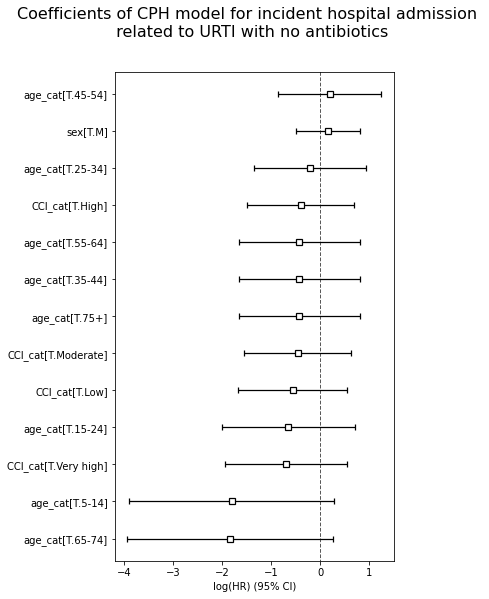

In [95]:
fig, ax = plt.subplots(figsize=(5, 9)
                        )
cph_urti_no_abs_incdt.plot()
plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
plt.savefig('../output/hospitalisation_prediction_urti/coefficients_cph_urti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [88]:
# # concordance index of cph model with testing data
# concord_index_urti_no_abs_incdt_test = concordance_index(data_urti_no_abs_incdt_test['event_urti_admitted'], -cph_urti_no_abs_incdt.predict_partial_hazard(data_urti_no_abs_incdt_test), data_urti_no_abs_incdt_test['duration_urti_admitted'])
# print(f'Concordance index for urti_no_abs_incdt with testing data: {concord_index_urti_no_abs_incdt_test}')
# # print(concordance_index(data_urti_no_abs_incdt_test['event_urti_admitted'], -cph_urti_no_abs_incdt.predict_partial_hazard(data_urti_no_abs_incdt_test), data_urti_no_abs_incdt_test['duration_urti_admitted']))

In [89]:
# a = [concord_index_urti_no_abs_incdt_test]
# np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_no_abs_incdt_test.txt', a, delimiter=',')

In [ ]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_incdt, data_urti_no_abs_incdt_train, t0=30)
# # plt.suptitle('Calibration of CPH model for incident hospital admission related to urti with no antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_incdt_train.jpg', bbox_inches='tight')
# plt.show()

# # t0 (float) – the time to evaluate the probability of event occurring prior at.
# # ICI – mean absolute difference between predicted and observed
# # E50 – median absolute difference between predicted and observed

In [90]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_incdt, data_urti_no_abs_incdt_test, t0=30)
# # plt.suptitle('Calibration of CPH model for incident hospital admission related to URTI with no antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_incdt_test.jpg', bbox_inches='tight')
# plt.show()

In [174]:
# print(cph_urti_no_abs_incdt.score(data_urti_no_abs_incdt_1_test))
# print(cph_urti_no_abs_incdt.concordance_index_)
# print(cph_urti_no_abs_incdt.AIC_partial_)
# print(cph_urti_no_abs_incdt.concordance_index_)

#### 4-1-2- Incident hospital admission related to URTI with antibiotics

In [95]:
# data_urti_abs_incdt.columns

In [96]:
# data_urti_abs_incdt.shape

In [97]:
# #keep relevant variables
# data_urti_abs_incdt = data_urti_abs_incdt[['age', 'bmi_imp', 'gp_count_imp', 'flu_vaccine', 'sex', 'region', #'season', 
#                                          'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'smoking_status_imp',
#                                          'meds_nonabs',
#                                          'event_urti_admitted', 'duration_urti_admitted']]

In [98]:
# # printing number of missing values in each variable 
# data_urti_abs_incdt.isnull().sum()

In [91]:
# #drop ros with missing values
# data_urti_abs_incdt = data_urti_abs_incdt.dropna(axis='rows')
# #data_urti_abs_incdt = data_urti_abs_incdt.drop(columns=['smoking_status'])
# data_urti_abs_incdt.isnull().sum()

In [100]:
# fold_thre = len(data_urti_abs_incdt)-round(len(data_urti_abs_incdt)/4)
# data_urti_abs_incdt_train = data_urti_abs_incdt.iloc[:fold_thre]
# data_urti_abs_incdt_test = data_urti_abs_incdt.iloc[fold_thre:]

# print(f'shape of data_urti_abs_incdt for training: {data_urti_abs_incdt_train.shape}')
# print(f'shape of data_urti_abs_incdt for testing: {data_urti_abs_incdt_test.shape}')

In [101]:
# cph_urti_abs_incdt = CoxPHFitter().fit(data_urti_abs_incdt_train,
#         duration_col='duration_urti_admitted',
#         event_col='event_urti_admitted',
#         formula="age + sex + bmi_imp + gp_count_imp + flu_vaccine + region + antibacterial_brit_imp + imd_imp + ethnicity_imp + smoking_status_imp + meds_nonabs" # season +
#         )
# cph_urti_abs_incdt.print_summary()

In [102]:
# output = GetPrintSummary(cph_urti_abs_incdt)

# with open('../output/hospitalisation_prediction_urti/cph_urti_abs_incdt_summary.html', "w") as fo:
#     print(fo.write(output))
#     fo.close()

In [103]:
# a = cph_urti_abs_incdt.baseline_hazard_
# # cph_urti_abs_incdt.baseline_survival_
# # cph_urti_abs_incdt.predict_cumulative_hazard(data_urti_abs_incdt, data_urti_abs_incdt['duration_urti_admitted']<=30)
# # cph_urti_abs_incdt.predict_survival_function(data_urti_abs_incdt)

# # save 
# np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_urti_abs_incdt.txt', a, delimiter=',')

In [104]:
# fig, ax = plt.subplots(figsize=(5, 9)
#                         )
# cph_urti_abs_incdt.plot()
# plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to URTI with antibiotics', fontsize=16)
# #_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
# #                        rotation=45, fontsize=12, ha='right')
# plt.savefig('../output/hospitalisation_prediction_urti/coefficients_cph_urti_abs_incdt.jpg', bbox_inches='tight')
# plt.show()

In [105]:
# # concordance index of cph model with testing data
# concord_index_urti_abs_incdt_test = concordance_index(data_urti_abs_incdt_test['event_urti_admitted'], -cph_urti_abs_incdt.predict_partial_hazard(data_urti_abs_incdt_test), data_urti_abs_incdt_test['duration_urti_admitted'])
# print(f'Concordance index for urti_abs_incdt with testing data: {concord_index_urti_abs_incdt_test}')

In [106]:
# a = [concord_index_urti_abs_incdt_test]
# np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_abs_incdt_test.txt', a, delimiter=',')

In [107]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_abs_incdt, data_urti_abs_incdt_train, t0=30)
# # plt.suptitle('Calibration of CPH model for incident hospital admission related to URTI with antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_incdt_train.jpg', bbox_inches='tight')
# plt.show()

In [108]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_abs_incdt, data_urti_abs_incdt_test, t0=30)
# # plt.suptitle('Calibration of CPH model for incident hospital admission related to urti with antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_incdt_test.jpg', bbox_inches='tight')
# plt.show()

#### 4-1-3- Prevalent hospital admission related to URTI with no antibiotics

In [109]:
# data_urti_no_abs_prevl.columns

In [111]:
# data_urti_no_abs_prevl.shape

In [112]:
# #keep relevant variables
# data_urti_no_abs_prevl = data_urti_no_abs_prevl[['age', 'bmi_imp', 'gp_count_imp', 'flu_vaccine', 'sex', 'region', #'season', 
#                                                 'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'smoking_status_imp',
#                                                 'meds_nonabs',
#                                                 'event_urti_admitted', 'duration_urti_admitted']]

In [113]:
# # printing number of missing values in each variable 
# data_urti_no_abs_prevl.isnull().sum()

In [98]:
# #drop rows with missing values
# data_urti_no_abs_prevl = data_urti_no_abs_prevl.dropna(axis='rows')
# #data_urti_no_abs_prevl = data_urti_no_abs_prevl.drop(columns=['smoking_status'])
# data_urti_no_abs_prevl.isnull().sum()

In [114]:
# data_urti_no_abs_prevl.shape

In [115]:
# fold_thre = len(data_urti_no_abs_prevl)-round(len(data_urti_no_abs_prevl)/4)
# data_urti_no_abs_prevl_train = data_urti_no_abs_prevl.iloc[:fold_thre]
# data_urti_no_abs_prevl_test = data_urti_no_abs_prevl.iloc[fold_thre:]

# print(f'shape of data_urti_no_abs_prevl for training: {data_urti_no_abs_prevl_train.shape}')
# print(f'shape of data_urti_no_abs_prevl for testing: {data_urti_no_abs_prevl_test.shape}')

In [116]:
# cph_urti_no_abs_prevl = CoxPHFitter().fit(data_urti_no_abs_prevl_train,
#         duration_col='duration_urti_admitted',
#         event_col='event_urti_admitted',
#         formula="age + sex + bmi_imp + gp_count_imp + flu_vaccine + region + antibacterial_brit_imp + imd_imp + ethnicity_imp + smoking_status_imp + meds_nonabs" # season +
#         )
# cph_urti_no_abs_prevl.print_summary()

In [117]:
# output = GetPrintSummary(cph_urti_no_abs_prevl)

# with open('../output/hospitalisation_prediction_urti/cph_urti_no_abs_prevl_summary.html', "w") as fo:
#     print(fo.write(output))
#     fo.close()

In [118]:
# a = cph_urti_no_abs_prevl.baseline_hazard_
# # cph_urti_no_abs_prevl.baseline_survival_
# # cph_urti_no_abs_prevl.predict_cumulative_hazard(data_urti_no_abs_prevl, data_urti_no_abs_prevl['duration_urti_admitted']<=30)
# # cph_urti_no_abs_prevl.predict_survival_function(data_urti_no_abs_prevl)

# # save 
# np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_urti_no_abs_prevl.txt', a, delimiter=',')

In [119]:
# fig, ax = plt.subplots(figsize=(5, 9)
#                         )
# cph_urti_no_abs_prevl.plot()
# plt.suptitle('Coefficients of CPH model for prevalent hospital admission \n related to URTI with no antibiotics', fontsize=16)
# #_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
# #                        rotation=45, fontsize=12, ha='right')
# plt.savefig('../output/hospitalisation_prediction_urti/coefficients_cph_urti_no_abs_prevl.jpg', bbox_inches='tight')
# plt.show()

In [120]:
# data_urti_no_abs_prevl_test.columns

In [122]:
# # concordance index of cph model with testing data
# concord_index_urti_no_abs_prevl_test = concordance_index(data_urti_no_abs_prevl_test['event_urti_admitted'], -cph_urti_no_abs_prevl.predict_partial_hazard(data_urti_no_abs_prevl_test), data_urti_no_abs_prevl_test['duration_urti_admitted'])
# print(f'Concordance index for cph_urti_no_abs_prevl with testing data: {concord_index_urti_no_abs_prevl_test}')

In [121]:
# a = [concord_index_urti_no_abs_prevl_test]
# np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_no_abs_prevl_test.txt', a, delimiter=',')

In [123]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_prevl, data_urti_no_abs_prevl_train, t0=30)
# plt.suptitle('Calibration of CPH model for prevalent hospital admission related to URTI with no antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_prevl_train.jpg', bbox_inches='tight')
# plt.show()

In [124]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_prevl, data_urti_no_abs_prevl_test, t0=30)
# plt.suptitle('Calibration of CPH model for prevalent hospital admission related to URTI with no antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_prevl_test.jpg', bbox_inches='tight')
# plt.show()

#### 4-1-4- Prevalent hospital admission related to URTI with antibiotics

In [385]:
# data_urti_abs_prevl.columns

In [386]:
# #keep relevant variables
# data_urti_abs_prevl = data_urti_abs_prevl[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
#                                         'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
#                                         'event_urti_admitted', 'duration_urti_admitted']]

In [387]:
# # print number of missing values in each variable 
# data_urti_abs_prevl.isnull().sum()

In [388]:
# #drop ros with missing values
# data_urti_abs_prevl = data_urti_abs_prevl.dropna(axis='rows')
# #data_urti_abs_prevl = data_urti_abs_prevl.drop(columns=['smoking_status'])
# data_urti_abs_prevl.isnull().sum()

In [389]:
# cph_urti_abs_prevl = CoxPHFitter(penalizer=0.1)
# cph_urti_abs_prevl.fit(data_urti_abs_prevl, 
#         duration_col='duration_urti_admitted',
#         event_col='event_urti_admitted',
#         formula="age_cat + sex + gp_count + flu_vaccine + region + antibacterial_brit + imd + ethnicity"
#         )
# cph_urti_abs_prevl.print_summary()

In [390]:
# fig, ax = plt.subplots(figsize=(5, 9)
#                         )
# cph_urti_abs_prevl.plot()
# plt.suptitle('Coefficients of CPH model for prevalent hospital admission related to URTI with antibiotics', fontsize=16)
# #_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
# #                        rotation=45, fontsize=12, ha='right')
# #plt.savefig('output/repeat_ABs_outputs/coefficients_cph_urti_abs_prevl.jpg', bbox_inches='tight')
# plt.show()

In [129]:
##save cph model with pickle package

# current_working_dir = os.getcwd()
# print(current_working_dir)

# with open('output/hospitalisation_prediction_urti/cph_urti_abs_prevl.pickle', 'wb') as f:
#     pickle.dump(cph_urti_abs_prevl, f)

# with open('output/hospitalisation_prediction_urti/cph_urti_abs_prevl.pickle', 'rb') as f:
#     cph_urti_abs_prevl = pickle.load(f)

# cph_urti_abs_prevl.summary

In [147]:
# hosp history, ab type history, 